# Imports

In [1]:
import os
import ast
import numpy as np
import pandas as pd
import logging
import pennylane as qml
import autograd.numpy as anp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from datetime import date

from pennylane import numpy as np_qml

from pennylane.optimize import SPSAOptimizer
from pennylane.optimize import AdamOptimizer
from pennylane.optimize import GradientDescentOptimizer
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn import cluster
from sklearn import preprocessing

from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, pairwise_kernels, pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel as sklearn_rbf_kernel

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_blobs, make_circles

from sklearn.model_selection import KFold

plt.style.use('dark_background')

seed = 42

np_qml.random.seed(seed)

# Obter o logger raiz
logger = logging.getLogger()
logger.setLevel(logging.INFO)  # Define o nível mínimo de mensagens

# Remover todos os handlers existentes (se houver)
if logger.hasHandlers():
    logger.handlers.clear()

# Criar um FileHandler para salvar as mensagens em um arquivo
file_handler = logging.FileHandler(f'log_{date.today().strftime("%d_%m_%Y")}.log')
file_handler.setLevel(logging.DEBUG)

# Definir o formato das mensagens de log
formatter = logging.Formatter(
    fmt='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
file_handler.setFormatter(formatter)

# Adicionar o FileHandler ao logger
logger.addHandler(file_handler)

# Circuit

In [ ]:
def default_embedding(x, wires):
    for i in wires:
        if i % 2 == 0:
            qml.RY(x[0], wires=i)
        else:
            qml.RX(x[1], wires=i)

# Ampliture Embedding
def amplitude_embedding(x, wires):
    qml.AmplitudeEmbedding(features=x, pad_with=2, wires=wires, normalize=True)

# Minimally Expressive Embedding (4 qubits, replicação de dados)
def minimally_expressive_embedding(x, wires):
    # Replicar dados: x[0] em qubits 0 e 2; x[1] em qubits 1 e 3
    for i in wires:
        if i % 2 == 0:
            qml.RX(x[0] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])   
        else:
            qml.RX(x[1] * 2 * np.pi, wires=wires[i])
            qml.RY(np.pi / 4, wires=wires[i])
            qml.RZ(np.pi / 4, wires=wires[i])

def entanglement(W, n_qubits, n_entanglement):
    for camada in range(len(W)):
        # Aplica rotações em cada qubit para a camada atual
        for qubit in range(n_qubits):
            params = W[camada][qubit]
            qml.Rot(params[0], params[1], params[2], wires=qubit)
        
        # Aplica o entrelaçamento baseado em n_entanglement
        for ent in range(n_entanglement):
            # Alterna o padrão de entrelaçamento com base na camada, ent e qubit
            for q in range(n_qubits - 1):
                if (camada + ent + q) % 2 == 0:
                    controle = q
                    alvo = (q + 1) % n_qubits
                else:
                    controle = (q + 1) % n_qubits
                    alvo = q
                qml.CNOT(wires=[controle, alvo])


def circuit(weights, X, n_quibits, n_entanglement, embedding_type = 'AE'):
    if embedding_type == 'AE':
        default_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'MEE':
        minimally_expressive_embedding(X, wires=range(n_quibits))
    elif embedding_type == 'AmpE':
        amplitude_embedding(X, wires=range(n_quibits))

    entanglement(weights, n_quibits, n_entanglement)
    # entanglement(weights, n_entanglement)

    return qml.expval(qml.PauliZ(wires=0))

def create_device(n_quibits):
    return qml.device("lightning.gpu", wires=n_quibits)

def create_qnode(n_quibits, n_entanglement, embedding_type):
    dev = create_device(n_quibits)

    @qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
    def qnode(weights, X):
        return circuit(weights, X, n_quibits, n_entanglement, embedding_type)

    return qnode

def qvc_classifier(qnode, w, b, X):
    return qnode(w, X) + b

# Compute Threshold

In [3]:
def compute_threshold(features, theta):
    # Features shape: (n_samples, 2)
    x1 = features[:, 0]
    x2 = features[:, 1]
    # Compute polynomial terms: 1, x1, x2, x1², x2², x1x2
    terms = np_qml.stack([np_qml.ones_like(x1), x1, x2, x1**2, x2**2, x1*x2], axis=1)
    
    # Combinação linear com regularização
    raw = terms @ theta
    
    # Função de compressão suave
    return np_qml.tanh(0.5 * raw) 

# Cluster Assingments

In [ ]:
def cluster_assingmens(X, phi, centroids, beta=0.5):
    similarities = np.zeros((X.shape[0], centroids.shape[0]))
    
    for i in range(X.shape[0]):
        for j in range(centroids.shape[0]):
            similarities[i, j] = hybrid_similarity(
                X[i], centroids[j, :-1], phi[i], centroids[j, -1], beta
            )
    
    return np.argmax(similarities, axis=1)  # Atribuição dura

# Show clusters

In [13]:
def print_decision_region(
        X, 
        qnode, 
        x_max, 
        y_max, 
        weights, 
        bias, 
        # threshold, 
        theta,
        complement = '',
        folder = "graph",
        graph_name = "test"
    ):
    cm = 'viridis'

    # Create subplots
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    # # Generate grid for decision boundaries
    xx, yy = np.meshgrid(np.linspace(0.0, x_max, 50), np.linspace(0.0, y_max, 50))
    X_grid = np.array([[x, y] for x, y in zip(xx.flatten(), yy.flatten())])

    # # Compute predictions and thresholds for grid points
    predictions_grid = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X_grid])
    thresholds_grid = compute_threshold(X_grid, theta)  # Your threshold function
    
    # # Reshape for plotting
    Z_pred = predictions_grid.reshape(xx.shape)
    Z_thresh = thresholds_grid.reshape(xx.shape)

    # ================= 3D Plot =================
    # Plot data points
    data_predictions = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in X])
    data_thresholds = compute_threshold(X, theta)
    cluster_labels = (data_predictions > data_thresholds).astype(int)

    sc = ax1.scatter(X[:,0], X[:,1], data_predictions, 
                    c=cluster_labels, cmap=cm, s=50, edgecolors='k', vmin=-1, vmax=1)
    
    # Plot threshold surface
    threshold_surface = ax1.plot_surface(xx, yy, Z_thresh, cmap='autumn', alpha=0.4, 
                                       label='Non-linear Threshold', vmin=-1, vmax=1)
    threshold_surface._facecolors2d = threshold_surface._facecolor3d  # For legend
    threshold_surface._edgecolors2d = threshold_surface._edgecolor3d
    
    ax1.set_title(f"3D Quantum Embedding\n{complement}")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")
    ax1.set_zlabel("Circuit Output")
    ax1.view_init(elev=15, azim=45)
    
    # ================= 2D Plot =================
    # Melhorias no gráfico 2D
    ax2.set_title(f"Mapa de Calor e Fronteira de Decisão\n{complement}", pad=20)

    # 1. Mapa de temperatura melhorado
    heatmap = ax2.contourf(xx, yy, Z_pred, levels=50, cmap='viridis', alpha=0.8)
    fig.colorbar(heatmap, ax=ax2, label='Saída do Circuito', shrink=0.8)

    # 2. Linha de interseção threshold-curva (fronteira de decisão principal)
    decision_line = ax2.contour(xx, yy, Z_pred - Z_thresh, levels=[0], 
                            colors='white', linewidths=2.5, linestyles='--')

    # 3. Linhas auxiliares para mostrar o comportamento do threshold
    threshold_contour = ax2.contour(xx, yy, Z_thresh, levels=7, colors='red', 
                                linewidths=0.8, alpha=0.5)

    # 4. Pontos com bordas contrastantes e transparência
    scatter = ax2.scatter(X[:,0], X[:,1], c=cluster_labels, cmap='coolwarm',
                        s=60, edgecolors='black', linewidth=0.8, alpha=0.9)

    # 6. Elementos adicionais
    ax2.grid(True, linestyle=':', alpha=0.3)
    ax2.set_aspect('equal', 'box')

    # Calculate and display metrics
    if len(np.unique(cluster_labels)) > 1:
        silhouette = silhouette_score(X, cluster_labels)
        davies = davies_bouldin_score(X, cluster_labels)
        calinski = calinski_harabasz_score(X, cluster_labels)

        metric_text = (
            f"Silhouette: {silhouette:.2f}\n"
            f"Davies-Bouldin: {davies:.2f}\n"
            f"Calinski-Harabasz: {calinski:.2f}"
        )
        
        fig.text(0.95, 0.95, metric_text,
                 transform=fig.gca().transAxes,
                 ha='right', va='top')
    else:
        fig.text(0.95, 0.95, "Metrics require\nmultiple clusters",
                 transform=plt.gca().transAxes,
                 ha='right', va='top')


    plt.tight_layout()
    plt.show()
    # # Save the plot
    # file_path = os.path.join(folder, graph_name)
    # plt.savefig(file_path)
    # plt.close()

# Show cost evolution

In [5]:
# Função para plotar a evolução
def plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history):
    plt.figure(figsize=(12, 6))

    epochs = range(1, len(intra_loss_history)+1)
    
    plt.plot(epochs, total_loss_history, 'w--', label='Total Loss', alpha=0.8)
    plt.plot(epochs, intra_loss_history, 'b', label='Intra Loss (Variância)')
    plt.plot(epochs, inter_loss_history, 'r', label='Inter Loss (Separação)')
    plt.plot(epochs, cluster_penality_history, 'g', label='Cluster Penality (Balanceamento)')
    
    plt.title('Evolução das Componentes da Função de Custo')
    plt.xlabel('Época')
    plt.ylabel('Valor da Loss')
    # plt.yscale('log')  # Para perdas variando muito
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.show()

# Cost

In [6]:
# Inicializa listas para armazenar as perdas
intra_loss_history = []
inter_loss_history = []
cluster_penality_history = []
total_loss_history = []

def cost_function(
        weights, 
        bias, 
        # threshold,
        theta, 
        qnode, 
        features, 
        alpha=0.3, 
        beta=0.4,
        gamma=0.3, 
        eps=1e-8
    ):
    #Saídas do circuito quântico e predições contínuas:
    raw_outputs = np_qml.array([qvc_classifier(qnode, weights, bias, x) for x in features])

    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################
    thresholds = compute_threshold(features, theta)
    continuous_preds = raw_outputs
    threshold = thresholds
    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################

    # continuous_preds = 2 / (1 + np_qml.exp(-raw_outputs)) - 1

    mask_0 = continuous_preds < threshold
    mask_1 = continuous_preds >= threshold
    
    # Médias dos clusters (com verificação de vazios):
    mean_0 = np_qml.mean(features[mask_0], axis=0) if np_qml.any(mask_0) else np_qml.zeros(features.shape[1])
    mean_1 = np_qml.mean(features[mask_1], axis=0) if np_qml.any(mask_1) else np_qml.zeros(features.shape[1])

    # Kernel RBF adaptativo
    gamma = 1.0 / (2.0 * np_qml.var(features) + eps)  # Ajusta-se à dispersão dos dados

    # Similaridades via kernel RBF:
    similarities_0 = np_qml.exp(-gamma * np_qml.linalg.norm(features - mean_0, axis=1)**2)
    similarities_1 = np_qml.exp(-gamma * np_qml.linalg.norm(features - mean_1, axis=1)**2)

    # Pesos com suavização (soft assignments)
    weights_0 = similarities_0 * (1.0 / (1.0 + np_qml.exp(continuous_preds - threshold)))
    weights_1 = similarities_1 * (1.0 / (1.0 + np_qml.exp(threshold - continuous_preds)))

    # Soft cluster sizes (differentiable)
    soft_n0 = np_qml.sum(weights_0)
    soft_n1 = np_qml.sum(weights_1)
    
    # Cluster balance penalty (avoids single-cluster dominance)
    cluster_penalty = 1/(soft_n0 + eps) + 1/(soft_n1 + eps)

    centroid_0 = np_qml.sum(continuous_preds * weights_0) / (np_qml.sum(weights_0) + eps)
    centroid_1 = np_qml.sum(continuous_preds * weights_1) / (np_qml.sum(weights_1) + eps)

    # Perdas Intra-Cluster e Inter-Cluster:
    intra_loss = (
        np_qml.sum(weights_0 * (continuous_preds - centroid_0)**2)/(np_qml.sum(weights_0) + eps) +
        np_qml.sum(weights_1 * (continuous_preds - centroid_1)**2)/(np_qml.sum(weights_1) + eps)
    ) / 2

    # Separação entre clusters com não-linearidade controlada
    centroid_diff = np_qml.tanh(centroid_1) - np_qml.tanh(centroid_0)
    inter_loss = np_qml.log(eps + np_qml.abs(centroid_diff))

    # reg_lambda = 0.01
    # reg_loss = reg_lambda * np_qml.sum(theta**2)

    total_loss = (
        alpha * intra_loss -
        beta * inter_loss +
        gamma * cluster_penalty
        # + reg_loss
    )

    if isinstance(inter_loss, np.ndarray):
        intra_loss_history.append(alpha * intra_loss.item())
        inter_loss_history.append(beta * inter_loss.item())
        cluster_penality_history.append(gamma * cluster_penalty.item())
        total_loss_history.append(total_loss.item())

    else:
        intra_loss_history.append(alpha * intra_loss._value)
        inter_loss_history.append(beta * inter_loss._value)
        cluster_penality_history.append(gamma * cluster_penalty._value)
        total_loss_history.append(total_loss._value)

    return total_loss

# Train Function

In [7]:
def train(
    qnode, 
    features,
    n_params,
    n_qubits,
    n_layers,
    weight_init_max, 
    optimizer,
    dic_optimizer,
    n_entanglement,
    embedding_type,
    cost,
    seed,
    iterations=100, 
    batch_size=32
):
    # Split data into 70% training and 30% validation
    X_train, X_val = train_test_split(features, test_size=0.3, shuffle=True, random_state=seed)

    all_costs = []  # To store cost values
    all_iterations = []

    # Initialize optimizer
    opt = optimizer(**dic_optimizer)
    
    # Initialize weights and bias with uniform distribution
    weights_init = np_qml.random.uniform(
        -weight_init_max, weight_init_max, 
        (n_layers, n_qubits, n_params), 
        requires_grad=True
    )
    bias_init = np_qml.array(0.0, requires_grad=True)

    weights = weights_init
    bias = bias_init

    # Define the folder path
    folder_name = "graphs"
    graph_name = f"E{n_entanglement} Emb({embedding_type}) O{optimizer.__name__} B{batch_size} Q{n_qubits} L{n_layers}.png"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################
    # Initialize threshold parameters (example: quadratic terms)
    theta = np_qml.random.uniform(-1, 1, (6,), requires_grad=True)  # For terms [1, x1, x2, x1², x2², x1x2]

    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################


    # initial_predictions = np.array([qvc_classifier(qnode, weights, bias, xi) for xi in features])
    # continuous_preds = 2 / (1 + np_qml.exp(-initial_predictions)) - 1
    # threshold = np_qml.median(continuous_preds)

    # Desenho do circuito
    qml.draw_mpl(qnode)(weights, features[0])

    training_info = {
        "best_weights": weights,
        "best_bias": bias,
        "best_cost": float('inf'),
        "silhouette": None,
        "davies_bouldin": None,
        "calinski_harabasz": None
    }

    patience = 50
    no_improvement = 0

    # Training loop
    for it in range(iterations):
        # Mini-batch sampling (ensure batch_size doesn't exceed training data size)
        current_batch_size = min(batch_size, len(X_train))
        # print(current_batch_size)
        batch_index = np.random.choice(len(X_train), current_batch_size, replace=False)
        X_train_batch = X_train[batch_index]

        wrapped_cost_function = lambda weights, bias, theta: cost(weights, bias, theta, qnode, X_train_batch)

        # Train model on batch
        params = [weights, bias, theta]
        (weights, bias, theta), iteration_cost = opt.step_and_cost(wrapped_cost_function, *params)
        
        # Update best weights and bias if cost improves
        if iteration_cost < training_info['best_cost']:
            training_info['best_weights'] = weights
            training_info['best_bias'] = bias
            training_info['best_theta'] = theta
            training_info['best_cost'] = iteration_cost
            no_improvement = 0
        else:
            no_improvement += 1

        all_costs.append(iteration_cost)
        all_iterations.append(it + 1)        

        logger.info(f"Iter: {it + 1:5d} | Cost: {iteration_cost:0.7f} | Best Cost: {training_info['best_cost']:0.7f}")

        # Early stopping if no improvement
        if no_improvement >= patience:
            break

    # Validation metrics
    predictions_val = np.array([qvc_classifier(qnode, training_info['best_weights'], training_info['best_bias'], xi) for xi in X_val])

    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################
    thresholds_val = compute_threshold(X_val, training_info['best_theta'])
    predictions_val = (predictions_val > thresholds_val)
    ####################################### TESTE THRESHOLD NAO LINEAR ##########################################
    
    # continuous_preds = 2 / (1 + np_qml.exp(-predictions_val)) - 1
    # predictions_val = np_qml.array(continuous_preds > training_info['best_threshold'])
    
    if len(np.unique(predictions_val)) > 1:
        training_info['davies_bouldin'] = davies_bouldin_score(X_val, predictions_val)
        training_info['calinski_harabasz'] = calinski_harabasz_score(X_val, predictions_val)
        training_info['silhouette'] = silhouette_score(X_val, predictions_val)

    print_decision_region(
        features, 
        qnode, 
        x_max=np.pi, 
        y_max=np.pi, 
        weights=training_info['best_weights'], 
        bias=training_info['best_bias'],
        theta=training_info['best_theta'],
        complement=f"E{n_entanglement} Emb({embedding_type}) O{optimizer.__name__} B{batch_size} Q{n_qubits} L{n_layers}",
        folder=folder_name,
        graph_name=graph_name
    )

    logger.info(f'Custo Final: {training_info["best_cost"]}')
    logger.info(f'Silhouette: {training_info["silhouette"]}')
    logger.info(f'Davies Bouldin: {training_info["davies_bouldin"]}')
    logger.info(f'Calinski Harabasz: {training_info["calinski_harabasz"]}')

    return (all_costs,
            training_info["best_cost"], 
            training_info["best_weights"], 
            training_info["best_bias"], 
            training_info['best_theta'], 
            training_info["silhouette"], 
            training_info["davies_bouldin"], 
            training_info["calinski_harabasz"])

# Normalize data

In [8]:
def normalize_data_transformY(X, y, range_init, range_end, plot=True):
  X_scaled = preprocessing.normalize(X,axis=0)

  scaler = preprocessing.MinMaxScaler(feature_range=(range_init, range_end))
  X_scaled = scaler.fit_transform(X)

  X = X_scaled

  if y is not None:
    y = 2*y - 1

  if plot:
    plt.figure(figsize=(4, 4))
    plt.title("Base de dados", fontsize="small")
    plt.scatter(X[:, 0], X[:, 1], marker="o", s=25, c=y if y is not None else None, edgecolor="k")
    plt.show()

  return X_scaled, y

# Calculate Composite Score

In [9]:
def calculate_composite_score(
    cost, 
    silhouette, 
    davies_bouldin, 
    calinski_harabasz,
    min_cost, max_cost,
    min_silhouette, max_silhouette,
    min_davies, max_davies,
    min_calinski, max_calinski
):
    # Normalização min-max com tratamento para divisão por zero
    def normalize(value, min_val, max_val, reverse=False):
        if max_val == min_val:
            return 0.5  # Valor neutro se todos forem iguais
        if reverse:
            return (max_val - value) / (max_val - min_val)  # Quanto menor, melhor
        else:
            return (value - min_val) / (max_val - min_val)  # Quanto maior, melhor

    # Aplicar normalização
    norm_cost = normalize(cost, min_cost, max_cost, reverse=True)
    norm_silhouette = normalize(silhouette, min_silhouette, max_silhouette) if silhouette is not None else 0
    norm_davies = normalize(davies_bouldin, min_davies, max_davies, reverse=True) if davies_bouldin is not None else 0
    norm_calinski = normalize(calinski_harabasz, min_calinski, max_calinski) if calinski_harabasz is not None else 0

    # Calcular pontuação composta (ajuste os pesos)
    composite_score = (
        0.3 * norm_cost +
        0.3 * norm_silhouette +
        0.2 * norm_davies +
        0.2 * norm_calinski
    )
    return composite_score

# Execution Function

# 2 Moons

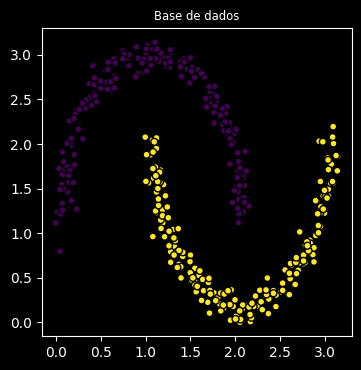

In [10]:
X, y = make_moons(n_samples=400, noise=0.05, random_state=seed)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

In [ ]:
n_qubits = [2, 4]
n_layers = [2, 4]
n_params = 3
circuits = {
    "type1": 1,
    "type2": 3,
    "type3": 5
}

optimizers = [
    SPSAOptimizer,
    NesterovMomentumOptimizer,
    AdamOptimizer,
    GradientDescentOptimizer
]

optimizer_params = {
    'NesterovMomentumOptimizer': {'stepsize': 0.01, 'momentum': 0.9},
    'GradientDescentOptimizer': {'stepsize': 0.01},
    'SPSAOptimizer': {'maxiter': 100, 'alpha': 0.602, 'c': 0.101, 'gamma': 0.101},
    'AdamOptimizer': {'stepsize': 0.01}
}

embedding_types = [
    "AE",
    "AmpE",
    "MEE"
]

batchs_size = [
    32,
    64
]

log_results = []

for batch_size in batchs_size:
    for qubits in n_qubits:
        for layers in n_layers:
            for optimizer in optimizers:
                for circuit_type in circuits.keys():
                    for embedding in embedding_types:
                        qnode = create_qnode(qubits, n_entanglement=circuits[circuit_type], embedding_type=embedding)

                        all_costs, cost, weights, bias, thresholds, score_silhouette, score_davies, score_calinski = train(
                            qnode=qnode,
                            features=X,
                            n_params=n_params,
                            n_qubits=qubits,
                            n_layers=layers,
                            weight_init_max=np.pi,
                            optimizer=optimizer,
                            dic_optimizer=optimizer_params[optimizer.__name__],
                            n_entanglement=circuits[circuit_type],
                            embedding_type=embedding,
                            cost=cost_function,
                            seed=seed,
                            iterations=100,
                            batch_size=batch_size
                        )

                        # Adicionar os resultados ao log
                        log_results.append({
                            'n_entanglement': circuits[circuit_type],
                            'optimizer': optimizer.__name__,
                            'n_qubits': qubits,
                            'n_layers': layers,
                            'score_davies': score_davies,
                            'score_calinski': score_calinski,
                            'score_silhouette': score_silhouette,
                            'cost': cost,
                            'weights': weights.tolist(),  # Convertendo para lista, caso seja um array
                            'bias': bias, # Convertendo para lista, caso seja um array
                            'qnode': qnode,
                            'all_costs': all_costs,
                            'embedding_type': embedding,
                            'batch_size': batch_size,
                            'thresholds': thresholds
                        })

# Salvar o log em um arquivo CSV
log_df = pd.DataFrame(log_results)
log_df.to_csv(f'moon_testes.csv', index=False)

/tmp/ipykernel_479/1350323778.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(14, 6))
/opt/venv/lib/python3.10/site-packages/pennylane/drawer/mpldrawer.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._fig = plt.figure(figsize=figsize)


## Execution

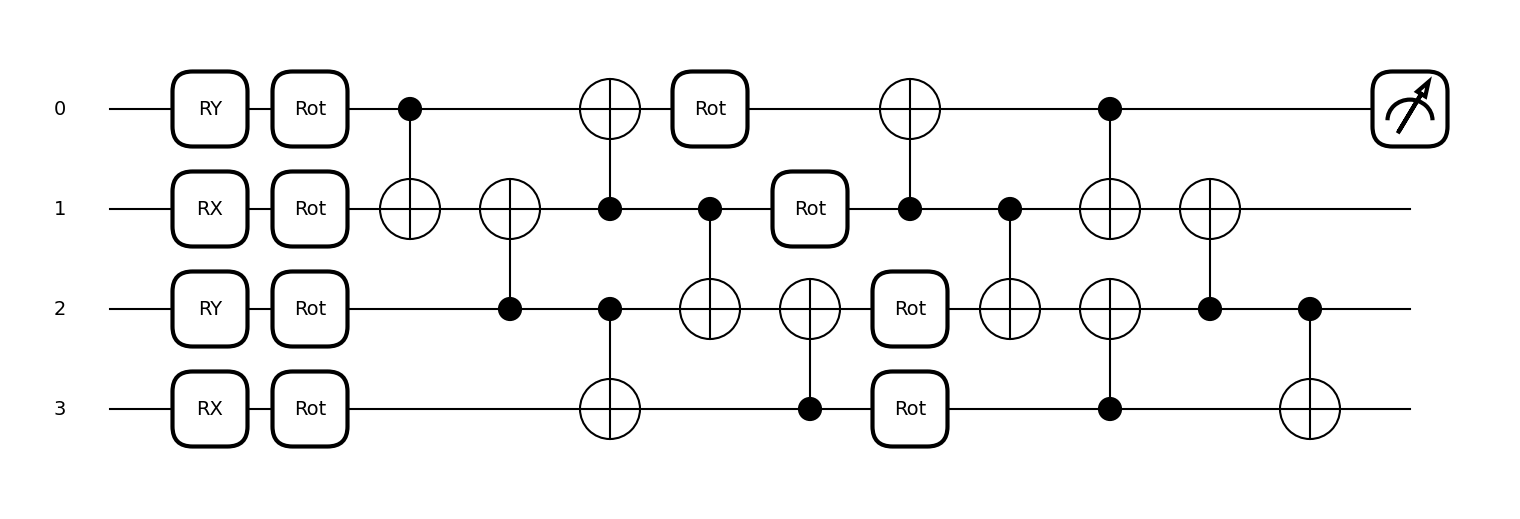

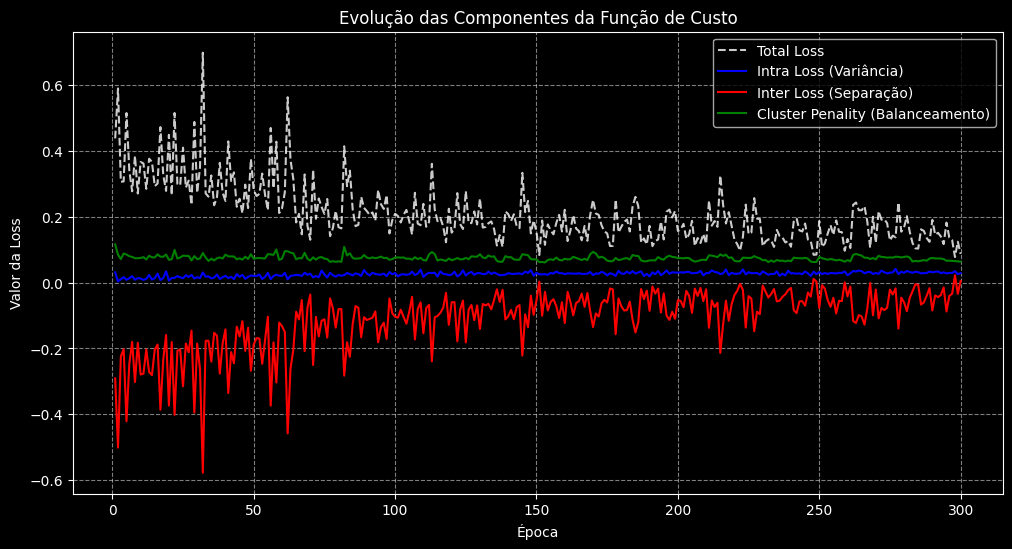

In [12]:
n_qubits = 4
n_params = 3
n_layers = 2
n_entanglement = 2
embedding_type = 'AE'
qnode = create_qnode(n_qubits, n_entanglement=n_entanglement, embedding_type=embedding_type)

intra_loss_history = []
inter_loss_history = []
cluster_penality_history = []
total_loss_history = []

all_costs, cost, weights, bias, threshold, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 100},
    n_entanglement=n_entanglement,
    embedding_type=embedding_type,
    cost=cost_function,
    seed=seed,
    iterations=100,
    batch_size=64
)

plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history)

# Blobs

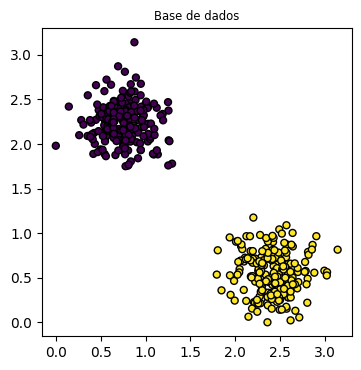

In [112]:
X, y = make_blobs(n_samples=400, centers=2, random_state=seed)

X, y = normalize_data_transformY(X,y, range_init=0, range_end=np.pi)

## Execution

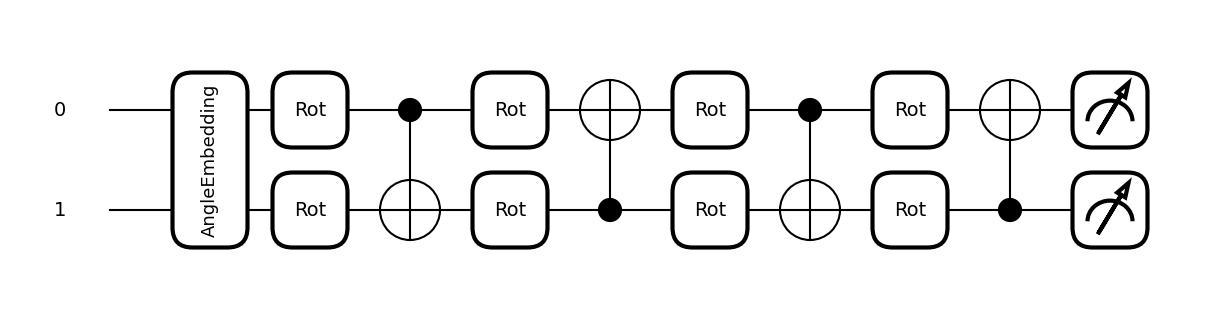

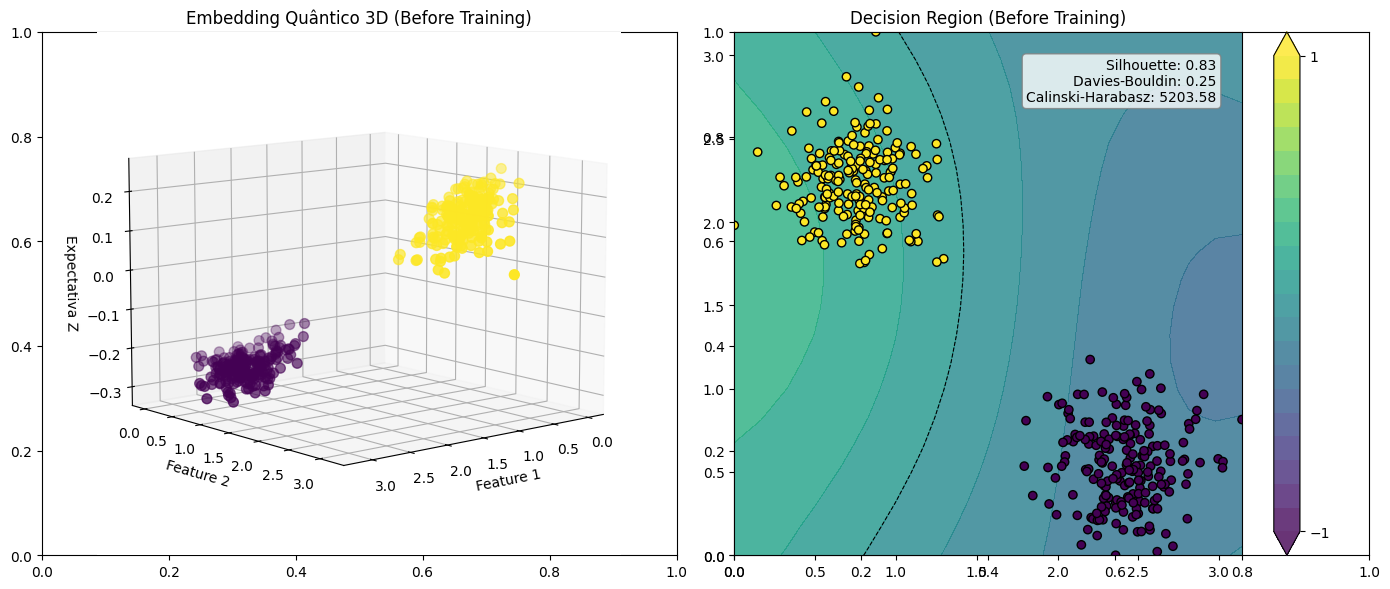

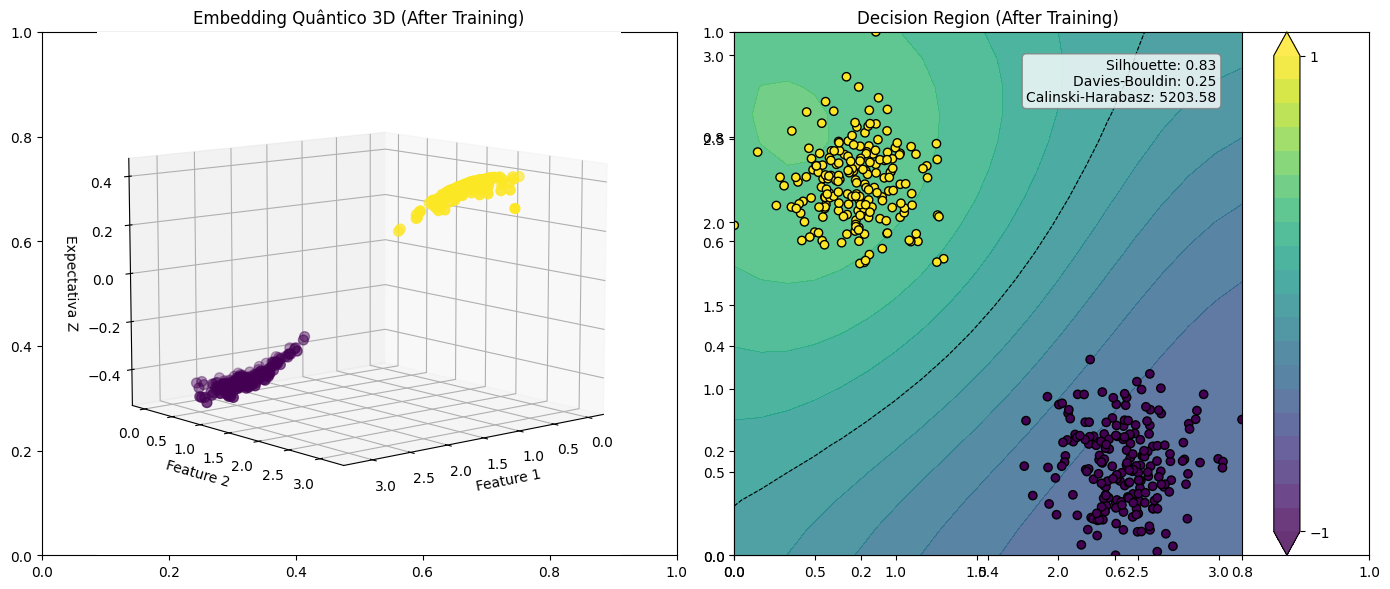

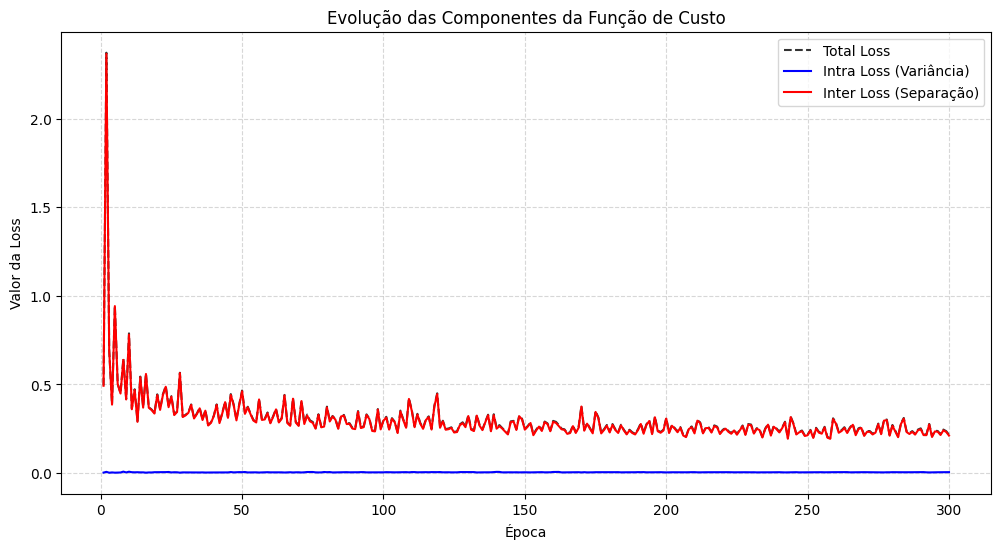

In [113]:
n_qubits = 2
n_params = 3
n_layers = 4
qnode = create_qnode(n_qubits, 1, embedding_type='AE')

intra_loss_history = []
inter_loss_history = []
total_loss_history = []

cost, weights, bias, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=SPSAOptimizer,
    dic_optimizer={"maxiter": 1000},
    seed=seed,
    iterations=100,
    batch_size=32
)

plot_loss_evolution(intra_loss_history, inter_loss_history, total_loss_history)

# Circles

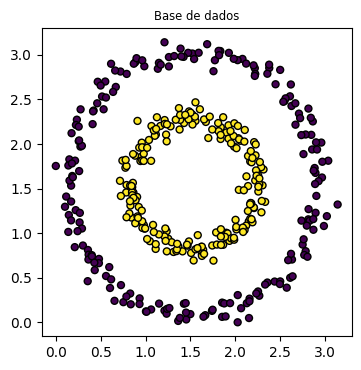

In [58]:
X, y = make_circles(
    (200, 200), factor=0.5, noise=0.05, random_state=seed
)

X, y = normalize_data_transformY(X, y, range_init=0, range_end=np.pi)

## Execution

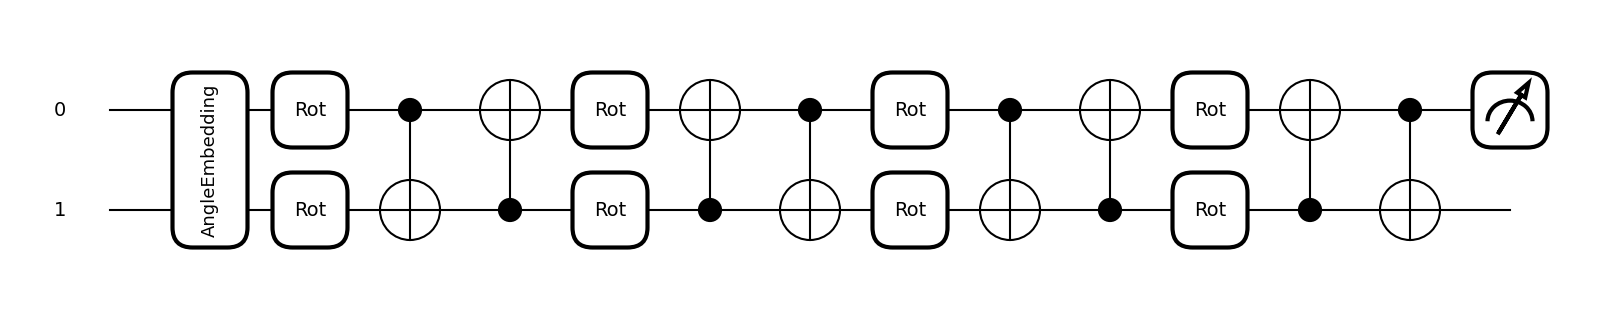

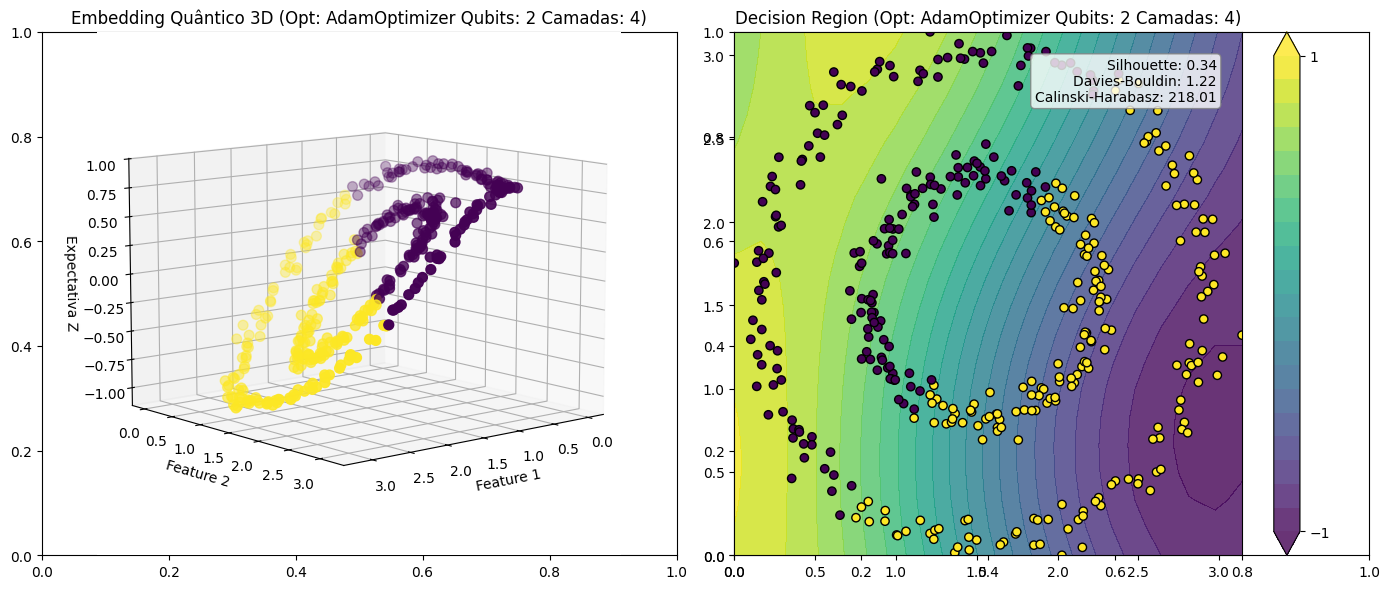

TypeError: plot_loss_evolution() missing 1 required positional argument: 'total_loss_history'

In [ ]:
n_qubits = 2
n_params = 3
n_layers = 4
qnode = create_qnode(n_quibits=n_qubits, n_entanglement=2, embedding_type="AE")

intra_loss_history = []
inter_loss_history = []
cluster_penality_history = []
total_loss_history = []

cost, weights, bias, thresholds, score_silhouette, score_davies, score_calinski = train(
    qnode=qnode,
    features=X,
    n_params=n_params,
    n_qubits=n_qubits,
    n_layers=n_layers,
    weight_init_max=np.pi,
    optimizer=AdamOptimizer,
    dic_optimizer={"stepsize": 0.01},
    cost=cost_function,
    seed=seed,
    iterations=100,
    batch_size=64
)

plot_loss_evolution(intra_loss_history, inter_loss_history, cluster_penality_history, total_loss_history)